# GAN to generate Devanagari characters using MLP based nets

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid, save_image
import torch.optim as optim

import os
import time
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline


In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('Running on device:', device)
if use_cuda:
    print('Using GPU:',
          torch.cuda.get_device_name(torch.cuda.current_device()))

def get_current_time_str():
    return str(datetime.now().strftime("%d-%b-%Y_%H_%M_%S"))

Running on device: cuda:0
Using GPU: TITAN RTX


# Create data-loaders

In [21]:
batch_size = 128

root = 'devnagari_data/'
expr_name = 'devnagari_ann_gan'
model_name_D = expr_name  + '_D'+ '_PyTorch_model.pt'
model_name_G = expr_name  + '_G'+ '_PyTorch_model.pt'
gan_out_dir = expr_name + '_samples'
if not os.path.exists(gan_out_dir):
    os.mkdir(gan_out_dir)

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    ])

train_data = datasets.ImageFolder(os.path.join(root, 'Train'),
                                  transform=train_transform)
train_data_len = len(train_data)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
class_names = train_data.classes
num_of_classes = len(train_data.classes)

print(f'Training images available: {len(train_data)}')

Training images available: 78200


# Generator and Discriminator Models

In [4]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_hidden_size, g_output_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(g_input_dim, g_hidden_size)
        self.fc2 = nn.Linear(g_hidden_size, g_hidden_size * 2)
        self.fc3 = nn.Linear(g_hidden_size * 2, g_hidden_size * 4)
        self.fc4 = nn.Linear(g_hidden_size * 4, g_output_dim)
        self.dropout = nn.Dropout(0.3)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        return torch.tanh(self.fc4(x))


class Discriminator(nn.Module):
    def __init__(self, d_input_dim, d_hidden_size, d_output_dim, image_w=32):
        super(Discriminator, self).__init__()
        self.image_w = image_w
        self.fc1 = nn.Linear(d_input_dim, d_hidden_size * 4)
        self.fc2 = nn.Linear(d_hidden_size * 4, d_hidden_size * 2)
        self.fc3 = nn.Linear(d_hidden_size * 2, d_hidden_size)
        self.fc4 = nn.Linear(d_hidden_size, d_output_dim)
        self.dropout = nn.Dropout(0.3)
    # forward method
    def forward(self, x):
        x = x.view(-1, self.image_w * self.image_w)
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

# Model hyper-params and Model objects

In [5]:
# build network
z_dim = 128
image_dim_w = 32
image_dim_h = 32
g_hidden_size = 64
d_hidden_size = 64
image_dim = image_dim_w * image_dim_h

G = Generator(g_input_dim=z_dim,
              g_hidden_size=d_hidden_size,
              g_output_dim=image_dim).to(device)
D = Discriminator(d_input_dim=image_dim,
                  d_hidden_size=d_hidden_size,
                  d_output_dim=1).to(device)
print(G)
print(D)

Generator(
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1024, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
Discriminator(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [6]:
# loss
criterion = nn.BCELoss()

# optimizer
learing_rate = 0.0002
G_optimizer = optim.Adam(G.parameters(), lr=learing_rate)
D_optimizer = optim.Adam(D.parameters(), lr=learing_rate)

# Loss calculation helper functions

In [7]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    
    if smooth:
        lables = torch.ones(batch_size) * 0.9
    else:
        lables = torch.ones(batch_size)
    
    lables = lables.to(device)
    loss = criterion(D_out.squeeze(), lables)
    
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    
    lables = torch.zeros(batch_size).to(device)
    loss = criterion(D_out.squeeze(), lables)
    
    return loss
    

# Training loop

In [8]:
n_epoch = 100
D_losses, G_losses = [], []

load_for_training = False

if load_for_training:
    D.load_state_dict(torch.load(model_name_D))
    G.load_state_dict(torch.load(model_name_G))

for epoch in range(n_epoch):
    epoch += 1

    D_losses_per_epoch, G_losses_per_epoch = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        D.train()
        G.train()

        x = x * 2 - 1  # rescale input images from [0,1) to [-1, 1)

        # Training of the Discriminator

        D_optimizer.zero_grad()
        D_real = D(x)
        D_real_loss = real_loss(D_real, smooth=False)

        z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        z = torch.from_numpy(z).float().to(device)
        fake_images = G(z)
        D_fake = D(fake_images)
        D_fake_loss = fake_loss(D_fake)

        D_total_loss = D_fake_loss + D_real_loss
        D_total_loss.backward()
        D_optimizer.step()

        # Training of the Generator

        G_optimizer.zero_grad()
        z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        z = torch.from_numpy(z).float().to(device)

        fake_images = G(z)

        D_fake = D(fake_images)
        G_loss = real_loss(D_fake)
        G_loss.backward()
        G_optimizer.step()

        D_losses_per_epoch.append(D_total_loss.item())
        G_losses_per_epoch.append(G_loss.item())

    mean_D_loss = np.mean(D_losses_per_epoch)
    mean_G_loss = np.mean(G_losses_per_epoch)

    D_losses.append(mean_D_loss)
    G_losses.append(mean_G_loss)

    print('epoch[%d/%d]: loss_d: %.8f, loss_g: %.8f' %
          ((epoch), n_epoch, mean_D_loss, mean_G_loss))

    with torch.no_grad():
        test_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        test_z = torch.from_numpy(test_z).float().to(device)
        G.eval()
        generated = G(test_z)
        save_image(
            generated.view(generated.size(0), 1, image_dim_w, image_dim_h),
            './{}/image_{}.png'.format(gan_out_dir, get_current_time_str()))
    torch.save(G.state_dict(), model_name_G)
    torch.save(D.state_dict(), model_name_D)

epoch[1/100]: loss_d: 0.73117822, loss_g: 1.39727360
epoch[2/100]: loss_d: 0.33532687, loss_g: 3.23110271
epoch[3/100]: loss_d: 0.17907207, loss_g: 4.37261724
epoch[4/100]: loss_d: 0.12789836, loss_g: 4.74502086
epoch[5/100]: loss_d: 0.14644973, loss_g: 5.07503987
epoch[6/100]: loss_d: 0.20426565, loss_g: 4.66954121
epoch[7/100]: loss_d: 0.17788254, loss_g: 4.71931038
epoch[8/100]: loss_d: 0.23835346, loss_g: 4.37422822
epoch[9/100]: loss_d: 0.21921286, loss_g: 4.22318083
epoch[10/100]: loss_d: 0.24292506, loss_g: 4.17582140
epoch[11/100]: loss_d: 0.26990123, loss_g: 3.96757324
epoch[12/100]: loss_d: 0.28305724, loss_g: 3.95529331
epoch[13/100]: loss_d: 0.34058559, loss_g: 3.73606525
epoch[14/100]: loss_d: 0.35092480, loss_g: 3.58257916
epoch[15/100]: loss_d: 0.38268869, loss_g: 3.46452850
epoch[16/100]: loss_d: 0.40113856, loss_g: 3.31335890
epoch[17/100]: loss_d: 0.44372168, loss_g: 3.15626379
epoch[18/100]: loss_d: 0.45661789, loss_g: 3.07186215
epoch[19/100]: loss_d: 0.47449715, lo

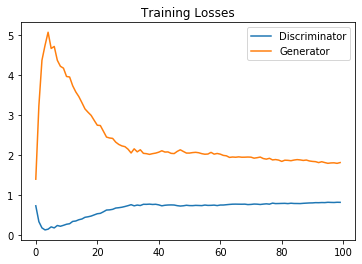

In [9]:
fig, ax = plt.subplots()

D_losses = np.array(D_losses)
G_losses = np.array(G_losses)

plt.plot(D_losses, label='Discriminator')
plt.plot(G_losses, label='Generator')
plt.title("Training Losses")
plt.legend()

# Generate sample output from trained Generator Model

In [11]:
sample_count = 10
for fc in range(sample_count):
    with torch.no_grad():
        G.eval()
        test_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
        test_z = torch.from_numpy(test_z).float().to(device)
        generated = G(test_z)

        save_image(generated.view(generated.size(0), 1, image_dim_w, image_dim_h),
                    './{}/final_{}_{}.png'.format(gan_out_dir, fc, get_current_time_str()))

# Save Sample inputs

In [13]:
train_iter = iter(train_loader)
data, _ = train_iter.next()
save_image(data.view(data.size(0), 1, image_dim_w, image_dim_h),
                    './{}/orig_{}.png'.format(gan_out_dir, get_current_time_str()))